Utiliser uniquement les fonctions dans les listes, sinon on recalcule tout à chaque fois !!!!
Tester si mes nouvelles fonctions coincident avec les anciennes en fast callable loin de 0

In [103]:
## Adding the .simplify_full() command may give cleaner functions to look at, but drastically increases the runtime (from 0.5 sec to more than 4 min), and, most importantly, causes completely unstable computations that ruin the precision (for unknown reasons).

prec = 300
RBF = RealBallField(prec)
var('x')
assume(x, 'real')
var('y')
assume(y, 'real')

n=10  # Number of derivatives to compute


W = (-x/2 + sqrt(1/27 + x^2/4))^(1/3) - (x/2 + sqrt(1/27 + x^2/4))^(1/3)
W_prime = diff(W, x)
a = 1 + W/x + W_prime
b = (3*x)/2 + W
a_derivs = [a]
a_derivs_0=[RBF(a_derivs[0].taylor(x,0))]
b_derivs = [b]
b_derivs_0=[RBF(b_derivs[0].taylor(x,0))]
for k in range(1, n):
    a_derivs.append(diff(a, x, k))
    a_derivs_0.append(RBF(a_derivs[k].taylor(x,0)))
    b_derivs.append(diff(b, x, k))
    b_derivs_0.append(RBF(b_derivs[k].taylor(x,0)))


phi_0 = -a_derivs[0] + b_derivs[1]/2 + a_derivs[2]/2 - a_derivs[4]/2 + a_derivs[6]/2
phi_1 = -a_derivs[0] - b_derivs[1]/2 + 2*a_derivs[2] + b_derivs[3]/2 - 3*a_derivs[4] - b_derivs[5]/2
phi_2 = -a_derivs[0] - (3/2)*b_derivs[1] + (9/2)*a_derivs[2] + (5/2)*b_derivs[3] 
phi_3 = -a_derivs[0] - (5/2)*b_derivs[1] # corresponds to the sign in the inequality
phi_list = [phi_0, phi_1, phi_2, phi_3]

phi_0_0 = -a_derivs_0[0] + b_derivs_0[1]/2 + a_derivs_0[2]/2 - a_derivs_0[4]/2 + a_derivs_0[6]/2
phi_1_0 = -a_derivs_0[0] - b_derivs_0[1]/2 + 2*a_derivs_0[2] + b_derivs_0[3]/2 - 3*a_derivs_0[4] - b_derivs_0[5]/2
phi_2_0 = -a_derivs_0[0] - (3/2)*b_derivs_0[1] + (9/2)*a_derivs_0[2] + (5/2)*b_derivs_0[3]
phi_3_0 = -a_derivs_0[0] - (5/2)*b_derivs_0[1]  
phi_list_0 = [phi_0_0, phi_1_0, phi_2_0, phi_3_0]


# Base Fourier function
f = (pi/4) * exp(-2*pi*abs(x)) * (2*(pi**2)*(x**2) + 3*pi*abs(x) + 3/2)
lambda_0 = f
lambda_1 = -diff(f, x)
lambda_2 = -diff(f, x, 2)
lambda_3 = 2*diff(f, x, 3)
lambda_4 = diff(f, x, 4)
lambda_list = [lambda_0,lambda_1,lambda_2,lambda_3,lambda_4]
lambda_list_0 = [limit(lambda_0,x=0),limit(lambda_1,x=0),limit(lambda_2,x=0),limit(lambda_3,x=0),limit(lambda_4,x=0)]


M_0 = (lambda_list[0](x=x - y) * phi_list[0](x=y))
M_1 = (lambda_list[1](x=x - y) * diff(phi_list[1], x)(x=y) + lambda_list[2](x=x - y) * phi_list[1](x=y))
M_2 = (lambda_list[3](x=x - y) * diff(diff(phi_list[2], x),x)(x=y) +lambda_list[3](x=x - y) * diff(phi_list[2], x)(x=y)+ lambda_list[4](x=x - y) * phi_list[2](x=y))
M_list=[M_0,M_1,M_2]


In [ ]:
def smooth_fast_callable(f,x,zero_value=RBF(0)):
    f_fast = fast_callable(f, vars=[x], domain=RBF)
    def f_modified(ball):
        return RBF(zero_value) if abs(RBF(ball).center()) <= 2**(-prec) else f_fast(ball) # Set the sensibility to be equal to the field precision
    return f_modified

# Convert symbolic functions to numerical ones evaluable on RealBallField elements
a_funcs = [smooth_fast_callable(a_derivs[k],x,a_derivs_0[k]) for k in range(n)]
b_funcs = [smooth_fast_callable(b_derivs[k],x,b_derivs_0[k]) for k in range(n)]
phi_funcs = [smooth_fast_callable(phi_list[k],x,phi_list_0[k]) for k in range(4)]
lambda_funcs = [smooth_fast_callable(lambda_list[k],x,lambda_list_0[k]) for k in range(5)]

In [114]:
phi_1_d1_0=diff(phi_list[1],x).taylor(x,0)
phi_1_d1_func=smooth_fast_callable(diff(phi_list[1],x),x,phi_1_d1_0)

phi_2_d1_0=diff(phi_list[2],x).taylor(x,0)
phi_2_d1_func=smooth_fast_callable(diff(diff(phi_list[2],x),x),x,phi_2_d1_0)
phi_2_d2_0=diff(diff(phi_list[2],x),x).taylor(x,0)
phi_2_d2_func=smooth_fast_callable(diff(diff(phi_list[2],x),x),x,phi_2_d2_0)


def M_0_func(ball1,ball2):
   return lambda_funcs[0](ball1-ball2)*phi_funcs[0](ball2)
    
def M_1_func(ball1, ball2):
    return (lambda_funcs[1](ball1-ball2) * phi_1_d1_func(ball2) + lambda_funcs[2](ball1-ball2) * phi_funcs[1](ball2))

def M_2_func(ball1, ball2):
    return (lambda_funcs[3](ball1-ball2) * phi_2_d2_func(ball2) + lambda_funcs[3](ball1-ball2) * phi_2_d1_func(ball2) + lambda_funcs[4](ball1-ball2) * phi_funcs[2](ball2))


M_funcs=[M_0_func,M_1_func,M_2_func]

In [116]:
print(fast_callable(a_derivs[1],vars=[x],domain=RBF)(RBF(1e-30)))
print(smooth_fast_callable(a_derivs[1],x,a_derivs_0[1])(RBF(0)))

# poursuivre ici les comparaisons entre nouvelles et anciennes

print(fast_callable(M_2,vars=[x,y],domain=RBF)(RBF(pi),RBF(pi)))
print(M_2_func(RBF(pi),RBF(pi)))

print(phi_funcs[0](1e-92))

[+/- 1.22e-29]
0
nan
[-4981.94101452456019965944107368059881287848598867441250711679916092651646926832104438034 +/- 2.04e-84]
34781.2500000000000000000000000000000000000000000000000000000000000000000000000000000000000000


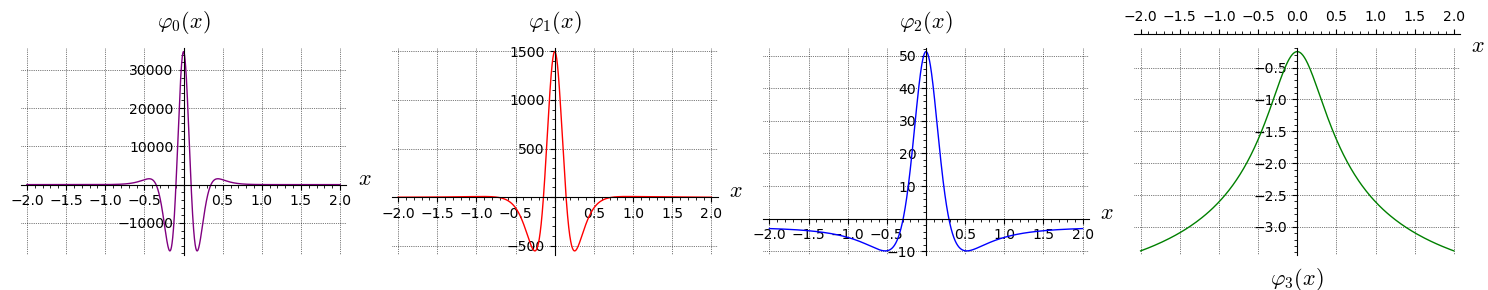

In [107]:
plots = []
colors = ['purple', 'red', 'blue', 'green', 'orange']

for k in range(4):
    axes_label = [r'$x$', f'$\\varphi_{{{k}}}(x)$']
    p = plot(phi_funcs[k], (x, -2, 2), color=colors[k],figsize=3,
             axes_labels=axes_label, gridlines=True)
    plots.append(p)

show(graphics_array([plots]), figsize=[15, 3])

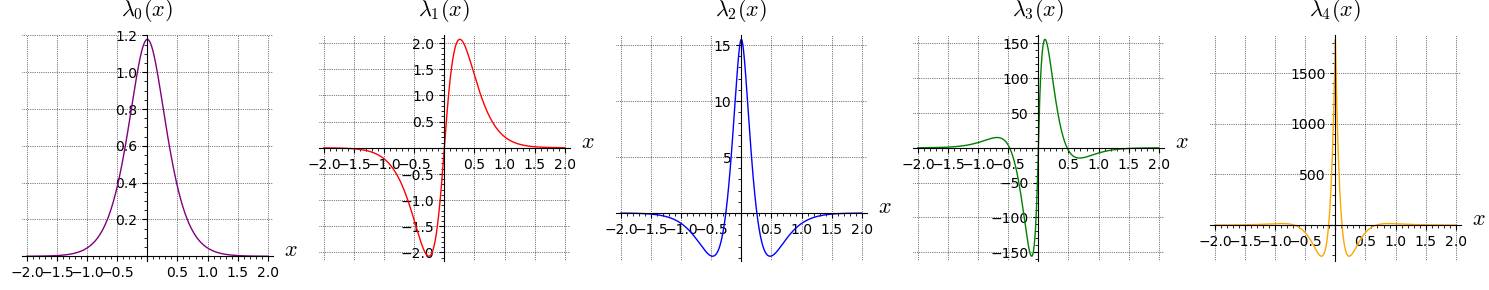

In [108]:
plots = []
colors = ['purple', 'red', 'blue', 'green', 'orange']

for k in range(5):
    axes_label = [r'$x$', f'$\\lambda_{{{k}}}(x)$']
    p = plot(lambda_funcs[k], (x, -2, 2), color=colors[k],figsize=3,
             axes_labels=axes_label, gridlines=True)
    plots.append(p)

show(graphics_array([plots]), figsize=[15, 3])

In [109]:
x0 = RBF(0.00001)

print("Evaluations of the derivatives of a at x =",float(x0),":")
for k in range(7):
    a_val = a_funcs[k](x0)
    print(f"d^{k}a/dx^{k}({x0.center():.2f}) = {a_val}")

Evaluations of the derivatives of a at x = 1e-05 :
d^0a/dx^0(0.00) = [-0.999999999600000000179999934461556927728148457565528156356015115547536403456483866060 +/- 4.25e-85]
d^1a/dx^1(0.00) = [7.99999999280000066018442954090451418302603007506383991200216667789567957271e-5 +/- 6.01e-80]
d^2a/dx^2(0.00) = [7.99999997840000002879999643530808036704307882998627405573429556791576037841 +/- 8.99e-75]
d^3a/dx^3(0.00) = [-0.00431999998848000037186919005791452155419451467809983061790114200052 +/- 5.77e-69]
d^4a/dx^4(0.00) = [-431.99999654400000923999941806625439340692582122669464729386168296 +/- 1.13e-63]
d^5a/dx^5(0.00) = [0.691199996304000066448893939345786641078719523081731933809 +/- 9.67e-58]
d^6a/dx^6(0.00) = [69119.998891200004953311805293271527846051226448098266191 +/- 5.09e-52]


In [121]:
# def rigorous_max_partial_derivatives(f, x1, x2, y1, y2):

#     I_x = R(x1, x2)
#     I_y = R(y1, y2)

#     fx = diff(f, x)
#     fy = diff(f, y)

#     fx_eval = R(fx(x=I_x, y=I_y))
#     fy_eval = R(fy(x=I_x, y=I_y))

#     fx_sup = R(max(abs(fx_eval.lower()), abs(fx_eval.upper())))
#     fy_sup = R(max(abs(fy_eval.lower()), abs(fy_eval.upper())))

#     return fx_sup, fy_sup

def riemann_integral(f,f_xprime,f_yprime, x1, x2, y1, y2, n):

    dx = (RBF(x2) - RBF(x1))/n
    dy = (RBF(y2) - RBF(y1))/n

    total = RBF(0)
    for i in range(n):
        for j in range(n):
            xi = RBF(x1) + i*dx
            yj = RBF(y1) + j*dy
            total += f(xi, yj) * dx * dy
            if f(xi,yj).is_NaN():
                print(yj.center())
            #sys.stdout.write(f"\rProgression : {int(((n*i+j) / (n**2)) * 100)}%") # Progress bar
            #sys.stdout.flush()

    #max_fx, max_fy = rigorous_max_partial_derivatives(f_expr, x1, x2, y1, y2)

    # Calcul borne d'erreur théorique
    # largeur = R(x2) - R(x1)
    # hauteur = R(y2) - R(y1)
    # error_bound = (largeur * hauteur / n) * (largeur * max_fx + hauteur * max_fy)
    return total #,error_bound

f_expr = M_funcs[0]
approx_integral  = riemann_integral(f_expr,0,0,-1,1,-1,1, n=100)

print(f"\rApproximation de l'intégrale : {approx_integral}")
# print(f"Borne d'erreur théorique (approx.) : {error_bound}")
# print("L'intégrale est contenue dans l'intervalle [",float((approx_integral-error_bound).lower()) ,",",float((approx_integral+error_bound).upper()),"]")

Approximation de l'intégrale : [-15.526163536565564797176776130940506656866017932543223927722591203345800079752 +/- 6.59e-76]
